In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from numpy import array

2022-09-19 23:35:51.722855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 23:35:51.722878: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Replace missing values with Zero and Gorup by month

In [2]:
df= pd.read_csv('colheitas.csv', parse_dates=['date'])
df['nr'].fillna(value=0, inplace=True)
df=df.groupby('date').sum()
df=df.resample(rule='MS').sum()
dataset = df.values
dataset = df.astype('float32')
#df.plot(figsize=(12,6))

### Split Train and Test

In [3]:
train=df[:240] 
test=df[240:]  

In [4]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
raw_seq = train['nr'].values.tolist()
n_steps_in, n_steps_out, slide = 24, 12, 1
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out, slide)

In [6]:
X[0], y[0]

(array([ 5422,  5375,  7687,  6114, 10217,  7244,  6889,  8386,  7997,
         8635, 10958,  9930,  9667,  9523,  9748,  9215, 11928,  9119,
         9575,  8960,  9547,  8913,  9951,  9675]),
 array([ 9394,  9100,  9153,  9118, 10799,  8499,  8065,  9094,  9609,
         9048, 12096, 11179]))

In [7]:
X[1], y[1]

(array([ 5375,  7687,  6114, 10217,  7244,  6889,  8386,  7997,  8635,
        10958,  9930,  9667,  9523,  9748,  9215, 11928,  9119,  9575,
         8960,  9547,  8913,  9951,  9675,  9394]),
 array([ 9100,  9153,  9118, 10799,  8499,  8065,  9094,  9609,  9048,
        12096, 11179, 12175]))

### Define and fit MLP model 

In [8]:
# split into samples
# define model
callback = EarlyStopping(monitor='loss', patience=50)
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(n_steps_in,)))
model.add(Dense(500, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0, callbacks=[callback])

2022-09-19 23:35:53.409026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-19 23:35:53.409058: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-19 23:35:53.409081: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-09-19 23:35:53.409358: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Plot losses per epoch

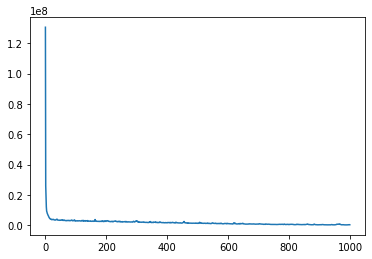

In [9]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### Test Predicitions

In [10]:
x_input = array([train['nr'][-n_steps_in:]])
x_input = x_input.reshape((1, n_steps_in))
yhat = model.predict(x_input)

### Calculate Error

In [11]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [12]:
np.sqrt(mean_squared_error(array([test['nr']]), yhat)), mean_absolute_error(array([test['nr']]), yhat), MAPE(array([test['nr']]), yhat)

(980.6769633012465, 769.78662109375, 4.373752785550762)

In [13]:
index_of_fc = pd.date_range(df[240:].index[0], periods = 12, freq='MS')
# make series for plotting purpose
collection_pred_mlp = pd.Series(array(yhat.tolist()[0]), index=index_of_fc)
%store collection_pred_mlp

Stored 'collection_pred_mlp' (Series)


In [14]:
collection_pred_mlp

2019-01-01    15009.144531
2019-02-01    16200.799805
2019-03-01    17386.867188
2019-04-01    17366.519531
2019-05-01    17252.007812
2019-06-01    15722.977539
2019-07-01    15741.310547
2019-08-01    15088.114258
2019-09-01    15538.401367
2019-10-01    17952.441406
2019-11-01    16497.144531
2019-12-01    16291.396484
Freq: MS, dtype: float64

### Plot

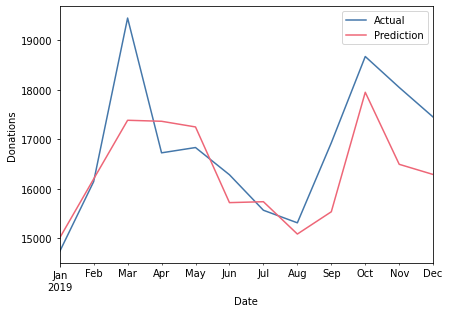

In [15]:
cm = 1/2.54 
test['nr'].plot(legend=True, color=['#4477AA'])
pd.DataFrame(yhat.tolist()[0], index=test.index.values, columns=['nr'])['nr'].plot(figsize=(17*cm,12*cm), color=['#EE6677'])
plt.legend(['Actual', 'Prediction'],loc='upper right')
plt.ylabel('Donations')
plt.xlabel('Date')